# Black Scholes Pricing Model
The goal of this Jupyter Notebook is to formally put the Black Scholes Model into Python. This is an option pricing model widely used in quantitative finance, designed to accurately price models.


#### Call Option Value:

$C = Se^{-qT}N(d_1) - Ke^{-rT}N(d_2)$

#### Put Option Value:

$P = Ke^{-rT}N(-d_2) - Se^{-qT}N(-d_1)$

___

#### $d_1$ and $d_2$

$$d_1 = \frac{ln(S/K) + (r - q + 0.5\sigma^2)}{\sigma \sqrt{T}}$$

$$d_2 = d_1 - \sigma \sqrt{T}$$

___

If we don't know volatility, we'll need the following 5 terms to understand it:

$S = 100$, Underlying Price

$K = 110$, Strike Price

$T = 1$, Time to maturity

$r = 0.05$, Risk-free rate

$q = 0$, Dividend Yield

Hedge funds are buying/selling volatility, and will be pricing volatility and capitalizing on that to find mispriced assets. The seventh variable is the price of the option, the market dictates that in some way.

It's called implied volatility because the Theo value of the option based on the market leads to finding sigma.

It's hard to find sigma, or volatility, using $d_1$.

## How can we do this?

We can make a loss function

In [1]:
import math
# jax is good for immediate differentiation?
from scipy.stats import norm
import numpy as np

def black_scholes(S, K, T, r, sigma, q=0, option_type="call"):
    """_summary_

    Args:
        S (float): _description_
        K (_type_): _description_
        T (_type_): _description_
        r (_type_): _description_
        sigma (_type_): _description_
        q (int, optional): _description_. Defaults to 0.
        option_type (str, optional): _description_. Defaults to "call".

    Returns:
        _type_: _description_
    """
    d1 = (math.log(S / K) + (r + (sigma**2) / 2) / (sigma * math.sqrt(T)))
    d2 = d1 - (sigma * math.sqrt(T))
    normal_distribution = norm(loc=0, scale=1)
    if option_type == "call":
        # it's a call option
        return S * (math.e**(-q * T)) * normal_distribution.cdf(d1) - K * (math.e**(-r * T)) * normal_distribution.cdf(d2)
    else:
        # it's a put, so we'll input the function for a put call
        return K * (math.e**(-r * T)) * normal_distribution.cdf(-d2) - S * (math.e**(-q * T)) * normal_distribution.cdf(-d1)
    
S, K, r, T, q = 100, 110, .05, 1, 0

def vega(S, K, T, r, sigma, q=0, option_type="call"):
    d1 = ((math.log(S / K) + (r + (sigma**2) / 2)) / (sigma * math.sqrt(T)))
    return S * math.exp(-q * T) * norm.pdf(d1) * math.sqrt(T)



In [2]:
def loss(S, K, T, r, price, sigma_guess=0.2, q = 0, option_type="call"):
    """_summary_

    Args:
        S (_type_): _description_
        K (_type_): _description_
        T (_type_): _description_
        r (_type_): _description_
        price (_type_): _description_
        sigma_guess (float, optional): _description_. Defaults to 0.2.
        q (int, optional): _description_. Defaults to 0.
        option_type (str, optional): _description_. Defaults to "call".

    Returns:
        _type_: _description_
    """
    # Price with the GUESS for the volatility
    theoretical_price = black_scholes(S, K, T, r, sigma_guess, q, option_type)
    
    # Actual Price
    market_price = price
    
    return theoretical_price - market_price

# 

# Newton Raphson Method to find Volatility iteratively
With Volatility, we are unable to solve for volatility through substitution or algebra. So, we need to make approximate guesses to what the volatility would be, by findng the volatility level such that the price of our Black-Scholes price is equal to the observed option price.

The Newton-Raphson Method is a simple algorithm used to find the root of a function, with $x_0$ being out initial guess. Once we approximate the function:

$$x_1 = x_0 - f(x_0) / f'(x_0)$$

THis is done with the second, thrid, anf future guesses, where a tolerance level is fixed and the algorithm is iterated upon until the difference between two consecutive estimations is below the level:

$$x_{n + 1} = x_n - /frac{f(x_n)}{f'(x_n)}$$
until $$\left| x_{n + 1} - x_n \right| \leq \varepsilon$$


In [3]:
def solve_for_iv(S, K, T, r, price, sigma_guess = 0.2, q=0, option_type="call"):
    """_summary_

    Args:
        S (float): Underlying Price
        K (float): Strike Price
        T (float): date to expiration (days)
        r (float): risk free rate
        price (_type_): _description_
        sigma_guess (float, optional): _description_. Defaults to 0.8.
        q (int, optional): _description_. Defaults to 0.
        option_type (str, optional): _description_. Defaults to "call".

    Returns:
        _type_: _description_
    """
    tolerance = 1e-6
    for i in range(100):
        price_diff = loss(S, K, T, r, price, sigma_guess, q, "call")
        v = vega(S, K, T, r, sigma_guess)
        if v == 0:
            break
        next_sigma = sigma_guess - (price_diff / v)
        if abs(next_sigma - sigma_guess) < tolerance:
            return next_sigma
        sigma_guess = next_sigma
    return float(sigma_guess)

In [4]:
# solving for impllied volatility should be around 0.2
solve_for_iv(100, 100, 1.0, .05, 10.45)

np.float64(0.199984448010944)

# Working with YFinance to visualize implied volatility

Now that we have put in a baseline idea of implied volatility, I'd like to extend this to actual data. I will use Microsoft from Yahoo Finance's yfinance API to illustrate implied volatility.

With Implied Volatility, it can be visualized in a 3-D plane:

X-Axis: Strike Price

Y-Axis: Implied Volatility

Z-Axis: Time to Expiration

In [5]:
import yfinance as yf
import pandas as pd

# ticker
tk = yf.Ticker("MSFT")
# extract expiration dates
exps = tk.options
df = pd.DataFrame()
for exp in exps:
    call_options = tk.option_chain(exp).calls
    call_options["expirationDate"] = exp
    df = pd.concat([df, call_options])
df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate
0,MSFT250627C00230000,2025-06-20 19:52:48+00:00,230.0,247.79,260.45,264.30,0.000000,0.000000,1.0,1.0,3.125002,True,REGULAR,USD,2025-06-27
1,MSFT250627C00275000,2025-05-30 18:58:21+00:00,275.0,185.54,215.50,219.40,0.000000,0.000000,1.0,1.0,2.583988,True,REGULAR,USD,2025-06-27
2,MSFT250627C00300000,2025-06-25 15:19:22+00:00,300.0,193.20,190.80,194.50,12.660004,7.012299,6.0,21.0,2.449223,True,REGULAR,USD,2025-06-27
3,MSFT250627C00320000,2025-06-25 17:51:17+00:00,320.0,171.01,170.50,174.55,11.459991,7.182696,2.0,1.0,2.048833,True,REGULAR,USD,2025-06-27
4,MSFT250627C00330000,2025-05-20 18:31:04+00:00,330.0,127.23,149.35,151.85,0.000000,0.000000,NaN,3.0,0.000010,True,REGULAR,USD,2025-06-27


In [6]:
# make sure we have different expiration dates
df["expirationDate"].unique()

array(['2025-06-27', '2025-07-03', '2025-07-11', '2025-07-18',
       '2025-07-25', '2025-08-01', '2025-08-15', '2025-09-19',
       '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20',
       '2026-05-15', '2026-06-18', '2026-09-18', '2026-12-18',
       '2027-01-15', '2027-06-17', '2027-12-17'], dtype=object)

In [7]:
import datetime
import time

time.time_ns()
time.time_ns()

1750889053717862000

In [8]:
df["expirationDate"] = df["expirationDate"].astype(str)

In [9]:
from datetime import date
import time

def convert_date_to_numeric(d):
    """
    Converts the datatype to a numeric value.

    Args:
        date (obj): the date from the dataframe

    Returns:
        an integer value for the date, relative to today.
    """
    if type(d) != "date":
        # convert date to string
        d = str(d)
        d = d.split("-")
        # split by - separator
        d = datetime.date(year=int(d[0]), month=int(d[1]), day=int(d[2]))
    # get the numeric value in second
    timestamp = time.mktime(d.timetuple())
    # there's 86400 seconds in a day, so convert it
    return timestamp / 86400

# Now, we need to calculate for time 
def calculate_T(expiration):
    """
    Calculates T  given the date of expiration,
    using datetime to extract the date.

    Args:
        expiration (str): The string form of the expiration date
    """
    # get current date
    expiration = convert_date_to_numeric(expiration)
    # convert dates to numeric values
    today = convert_date_to_numeric(date.today())
    # return T, which would be (expiration - current date) / 365
    return expiration - today
df["T"] = df["expirationDate"].apply(lambda x: calculate_T(x))
df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate,T
0,MSFT250627C00230000,2025-06-20 19:52:48+00:00,230.0,247.79,260.45,264.30,0.000000,0.000000,1.0,1.0,3.125002,True,REGULAR,USD,2025-06-27,2.0
1,MSFT250627C00275000,2025-05-30 18:58:21+00:00,275.0,185.54,215.50,219.40,0.000000,0.000000,1.0,1.0,2.583988,True,REGULAR,USD,2025-06-27,2.0
2,MSFT250627C00300000,2025-06-25 15:19:22+00:00,300.0,193.20,190.80,194.50,12.660004,7.012299,6.0,21.0,2.449223,True,REGULAR,USD,2025-06-27,2.0
3,MSFT250627C00320000,2025-06-25 17:51:17+00:00,320.0,171.01,170.50,174.55,11.459991,7.182696,2.0,1.0,2.048833,True,REGULAR,USD,2025-06-27,2.0
4,MSFT250627C00330000,2025-05-20 18:31:04+00:00,330.0,127.23,149.35,151.85,0.000000,0.000000,NaN,3.0,0.000010,True,REGULAR,USD,2025-06-27,2.0


In [10]:
df.dtypes

contractSymbol                    object
lastTradeDate        datetime64[ns, UTC]
strike                           float64
lastPrice                        float64
bid                              float64
ask                              float64
change                           float64
percentChange                    float64
volume                           float64
openInterest                     float64
impliedVolatility                float64
inTheMoney                          bool
contractSize                      object
currency                          object
expirationDate                    object
T                                float64
dtype: object

In [11]:
# the underlying price is the current price of the asset
def get_price():
    """gets the current price of an asset

    Returns:
        float_: the price of an underlying asset, S
    """
    msft = yf.Ticker("MSFT")
    S = float(msft.history(period="1d")["Close"][-1])
    return S
price = get_price()
# let's compute the implied volatility, and compare it with the implied Volatility Calculated in our dataframe
df["impliedVolatilityNoAssumptions"] = df.apply(lambda x: solve_for_iv(price, x["strike"], x["T"], .0454, x["lastPrice"]), axis=1)
df.head()

/var/folders/0k/yhkmq1794zv376jyrhx31f6c0000gn/T/ipykernel_23488/2218116541.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = float(msft.history(period="1d")["Close"][-1])
/var/folders/0k/yhkmq1794zv376jyrhx31f6c0000gn/T/ipykernel_23488/3276434418.py:23: RuntimeWarning: overflow encountered in scalar divide
  next_sigma = sigma_guess - (price_diff / v)
/var/folders/0k/yhkmq1794zv376jyrhx31f6c0000gn/T/ipykernel_23488/3020457181.py:21: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (math.log(S / K) + (r + (sigma**2) / 2) / (sigma * math.sqrt(T)))
/var/folders/0k/yhkmq1794zv376jyrhx31f6c0000gn/T/ipykernel_23488/3020457181.py:34: RuntimeWarning: invalid value encountered in scalar divide
  d1 = ((math.log(S / K) + (r + (sigma**2) / 2)) / (sigma * math.sqrt(T)))
/var/folders/0k/yhk

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate,T,impliedVolatilityNoAssumptions
0,MSFT250627C00230000,2025-06-20 19:52:48+00:00,230.0,247.79,260.45,264.30,0.000000,0.000000,1.0,1.0,3.125002,True,REGULAR,USD,2025-06-27,2.0,1.142421e+04
1,MSFT250627C00275000,2025-05-30 18:58:21+00:00,275.0,185.54,215.50,219.40,0.000000,0.000000,1.0,1.0,2.583988,True,REGULAR,USD,2025-06-27,2.0,3.424288e-03
2,MSFT250627C00300000,2025-06-25 15:19:22+00:00,300.0,193.20,190.80,194.50,12.660004,7.012299,6.0,21.0,2.449223,True,REGULAR,USD,2025-06-27,2.0,3.976158e-01
3,MSFT250627C00320000,2025-06-25 17:51:17+00:00,320.0,171.01,170.50,174.55,11.459991,7.182696,2.0,1.0,2.048833,True,REGULAR,USD,2025-06-27,2.0,-4.116563e+02
4,MSFT250627C00330000,2025-05-20 18:31:04+00:00,330.0,127.23,149.35,151.85,0.000000,0.000000,NaN,3.0,0.000010,True,REGULAR,USD,2025-06-27,2.0,-1.911113e+19


# Visualizing Implied Volatility

In [12]:
# Need to calculate the moneyness for X axis
df["moneyness"] = df["strike"] / price
df.head() 

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate,T,impliedVolatilityNoAssumptions,moneyness
0,MSFT250627C00230000,2025-06-20 19:52:48+00:00,230.0,247.79,260.45,264.30,0.000000,0.000000,1.0,1.0,3.125002,True,REGULAR,USD,2025-06-27,2.0,1.142421e+04,0.467223
1,MSFT250627C00275000,2025-05-30 18:58:21+00:00,275.0,185.54,215.50,219.40,0.000000,0.000000,1.0,1.0,2.583988,True,REGULAR,USD,2025-06-27,2.0,3.424288e-03,0.558637
2,MSFT250627C00300000,2025-06-25 15:19:22+00:00,300.0,193.20,190.80,194.50,12.660004,7.012299,6.0,21.0,2.449223,True,REGULAR,USD,2025-06-27,2.0,3.976158e-01,0.609422
3,MSFT250627C00320000,2025-06-25 17:51:17+00:00,320.0,171.01,170.50,174.55,11.459991,7.182696,2.0,1.0,2.048833,True,REGULAR,USD,2025-06-27,2.0,-4.116563e+02,0.650050
4,MSFT250627C00330000,2025-05-20 18:31:04+00:00,330.0,127.23,149.35,151.85,0.000000,0.000000,NaN,3.0,0.000010,True,REGULAR,USD,2025-06-27,2.0,-1.911113e+19,0.670364


In [20]:
df.to_csv("microsoft.csv", index=False)

Text(0.5, 0.92, "Microsoft's Implied Volatility Surface")

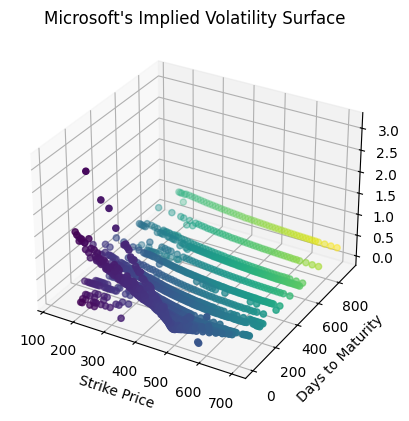

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# create figure and axis
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# make 3-D data. x will be strike, y axis is time to expiry, and z being implied volatility.
# since it's a 3d plot, x, y, and z must be 2 dimensional.
X = df["strike"]
Y = df["T"]
Z = df["impliedVolatility"]

fig = plt.figure()

scatter = ax.scatter(X, Y, Z, c=X + Y)

ax.set_xlabel("Strike Price")
ax.set_ylabel("Days to Maturity")
ax.set_title("Microsoft's Implied Volatility Surface")

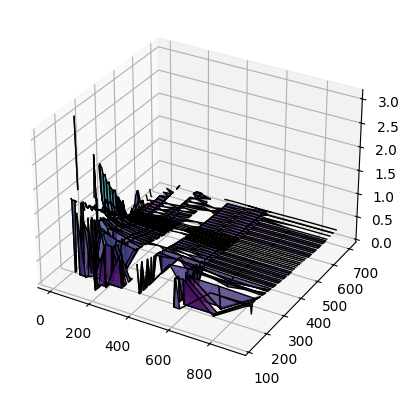

In [14]:
ax = plt.axes(projection="3d")
z = df.pivot_table(index="strike", columns="T", values="impliedVolatility")
x, y = np.meshgrid(z.columns.values, z.index.values)
ax.plot_surface(x, y, z, cmap="viridis", edgecolor="k", alpha=0.8)

Text(0, 0.5, 'Implied Volatility')

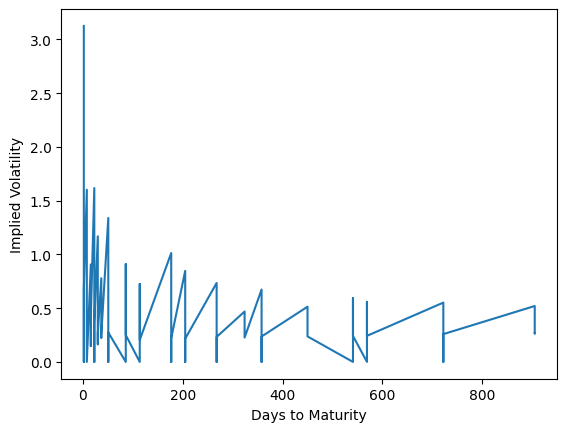

In [15]:
fig, ax = plt.subplots()
ax.plot(df["T"], df["impliedVolatility"])
ax.set_xlabel("Days to Maturity")
ax.set_ylabel("Implied Volatility")

# Interpolation

Notice how the surface isn't smooth? Need to create something to take care of that

Scipy's Interpolation module should help in that endeavor

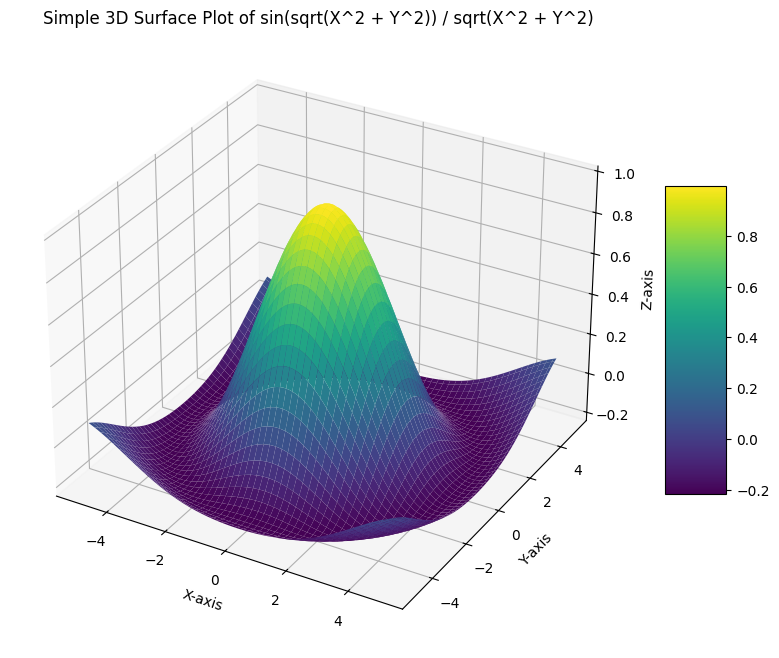

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Create the data for the surface ---
# Define the range for x and y values
x = np.linspace(-5, 5, 100) # 100 points between -5 and 5
y = np.linspace(-5, 5, 100) # 100 points between -5 and 5

# Create a 2D grid from x and y arrays
# X and Y will be 2D arrays, representing the coordinates of the grid points
X, Y = np.meshgrid(x, y)

# Define a simple function for Z (the height of the surface)
# This example uses the 'sinc' function, which creates a wave-like pattern
# Avoid division by zero by adding a small epsilon
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R) / (R + 1e-6) # Adding 1e-6 to avoid division by zero at R=0

# --- 2. Set up the 3D plot ---
fig = plt.figure(figsize=(10, 8)) # Create a new figure
ax = fig.add_subplot(111, projection='3d') # Add a 3D subplot to the figure

# --- 3. Plot the surface ---
# plot_surface takes the 2D grid arrays X, Y, and Z
# cmap defines the colormap (e.g., 'viridis', 'plasma', 'cividis')
# edgecolor adds lines around the faces for better definition
surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# --- 4. Customize the plot (optional but good practice) ---
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Simple 3D Surface Plot of sin(sqrt(X^2 + Y^2)) / sqrt(X^2 + Y^2)')

# Add a color bar to indicate Z values
fig.colorbar(surface, shrink=0.5, aspect=5)

# --- 5. Display the plot ---
plt.show()


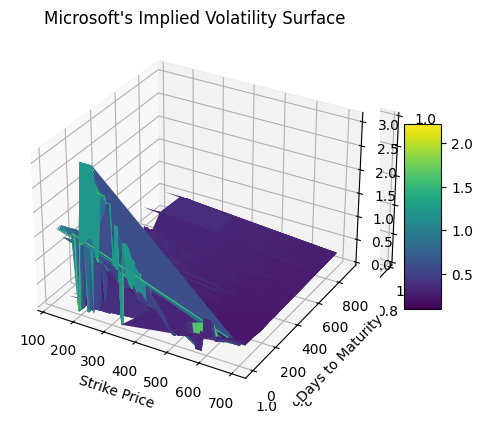

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.interpolate import griddata

# create figure and axis
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# make 3-D data. x will be strike, y axis is time to expiry, and z being implied volatility.
# since it's a 3d plot, x, y, and z must be 2 dimensional.
X = df["strike"]
Y = df["T"]
x, y = np.meshgrid(X, Y)
R = np.sqrt(x**2, y**2)
Z = griddata((X, Y), df["impliedVolatility"], (x, y), method="nearest")

ax = fig.add_subplot(111, projection="3d")

surface = ax.plot_surface(x, y, Z, cmap="viridis", edgecolor="none")


ax.set_xlabel("Strike Price")
ax.set_ylabel("Days to Maturity")
ax.set_title("Microsoft's Implied Volatility Surface")

ax.view_init(elev=30, azim=-60) # Changed to improve viewing angle

# Add a color bar
fig.colorbar(surface, shrink=0.5, aspect=5)

# --- 7. Display the plot ---
plt.show()


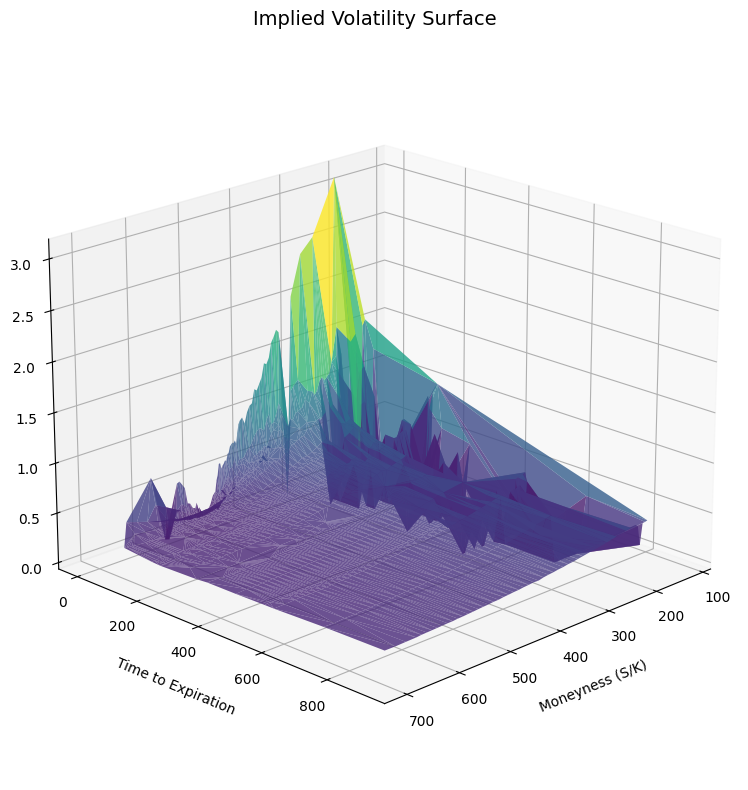

In [18]:
fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
Z = df["impliedVolatility"]
surf = ax.plot_trisurf(X, Y, Z,
                       cmap="viridis",
                       linewidth=0.1,
                       antialiased=True,
                       alpha=0.8)
ax.set_xlabel("Moneyness (S/K)", labelpad=10)
ax.set_ylabel("Time to Expiration", labelpad=10)
ax.set_zlabel("Implied Volatility", labelpad=10)
plt.title("Implied Volatility Surface", pad=20, size=14)
ax.view_init(elev=20, azim=45)
plt.tight_layout()

# Monte Carlo Pricing
Next, we would like to figure out Monte Carlo Pricing and have some sort of pricing model to get this done.  In the real world, black-scholes is deterministic, but the reality is that the world will need some sort of stochastic model given the variance and natural stochasticity of the world.